### 2d U-Net Implementation

I would like to give credit to Rastislav who inspired this model. The original code the model is based off is here: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net#Train-model

In [56]:
import os
# import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps   


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
# import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [1]:
# pip install SimpleITK tqdm matplotlib nibabel albumentations pydicom nibabel torch torchvision opencv-python scikit-image nilearn

In [5]:
# pip install opencv-python

In [4]:
# import cv2

In [6]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [7]:
import os
import random

# Directory containing data
data_directory = '/data'

# skip this path as it is empty
excluded_path = '/data/UCSF-PDGM-0541_nifti'
excluded_dirname = os.path.basename(excluded_path)
if excluded_path in data_directory:
    data_directory = data_directory.replace(excluded_path, '')

# List all files in the directory
all_files = os.listdir(data_directory)



# Shuffle the list of files
random.shuffle(all_files)

# the number of files for training and validation
num_train_files = 400

# Split the shuffled list into training and validation sets
train_files = all_files[:num_train_files]
val_files = all_files[num_train_files:]

# Define the paths for training and validation datasets
TRAIN_DATASET_PATH = [os.path.join(data_directory, file) for file in train_files]
VAL_DATASET_PATH = [os.path.join(data_directory, file) for file in val_files]

# Print the first few file paths for verification
print("Training Dataset Paths:")
print(TRAIN_DATASET_PATH[:5])  # Print the first 5 paths
print("\nValidation Dataset Paths:")
print(VAL_DATASET_PATH[:5])    # Print the first 5 paths


Training Dataset Paths:
['/data/UCSF-PDGM-0194_nifti', '/data/UCSF-PDGM-0247_nifti', '/data/UCSF-PDGM-0499_nifti', '/data/UCSF-PDGM-0481_nifti', '/data/UCSF-PDGM-0507_nifti']

Validation Dataset Paths:
['/data/UCSF-PDGM-0345_nifti', '/data/UCSF-PDGM-0381_nifti', '/data/UCSF-PDGM-0312_nifti', '/data/UCSF-PDGM-0034_nifti', '/data/UCSF-PDGM-0298_nifti']


In [10]:

ID = "UCSF-PDGM-0498_nifti"

# List files within the directory 
if ID in train_files:
    id_directory = os.path.join(data_directory, ID)
    files = os.listdir(id_directory)

    # Load NIfTI files 
    if len(files) == 23:
        _t1 = nib.load(os.path.join(id_directory, files[11])).get_fdata()
        _flair = nib.load(os.path.join(id_directory, files[15])).get_fdata()
        _t1ce = nib.load(os.path.join(id_directory, files[20])).get_fdata()
        _t2 = nib.load(os.path.join(id_directory, files[19])).get_fdata()
        _mask = nib.load(os.path.join(id_directory, files[9])).get_fdata()

        # You can now work with these loaded data arrays
    else:
        print(f"Expected 23 files for ID '{ID}', but found {len(files)} files.")
else:
    print(f"ID '{ID}' not found in the training set.")

Text(0.5, 1.0, 'Mask')

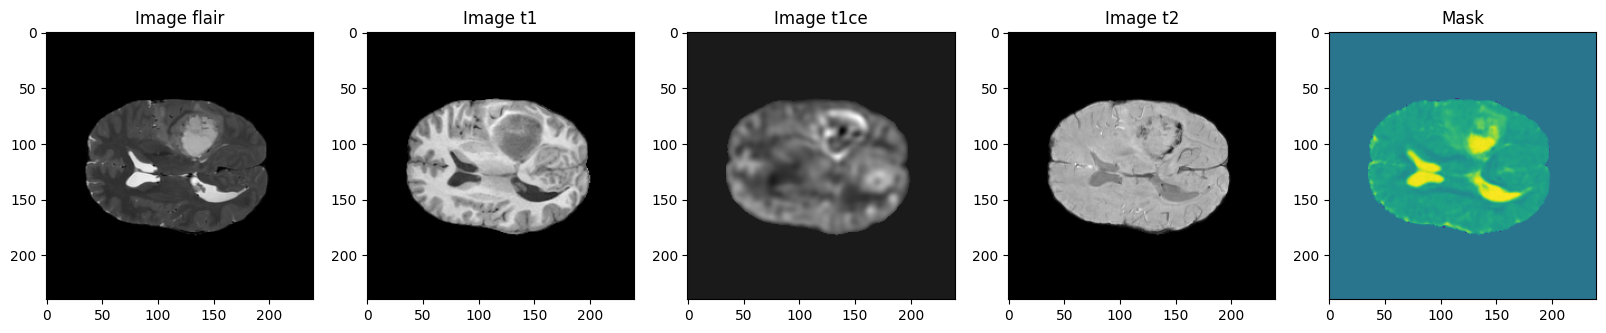

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(_flair[:,:,_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(_t1[:,:,_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(_t1ce[:,:,_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(_t2[:,:,_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(_mask[:,:,_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

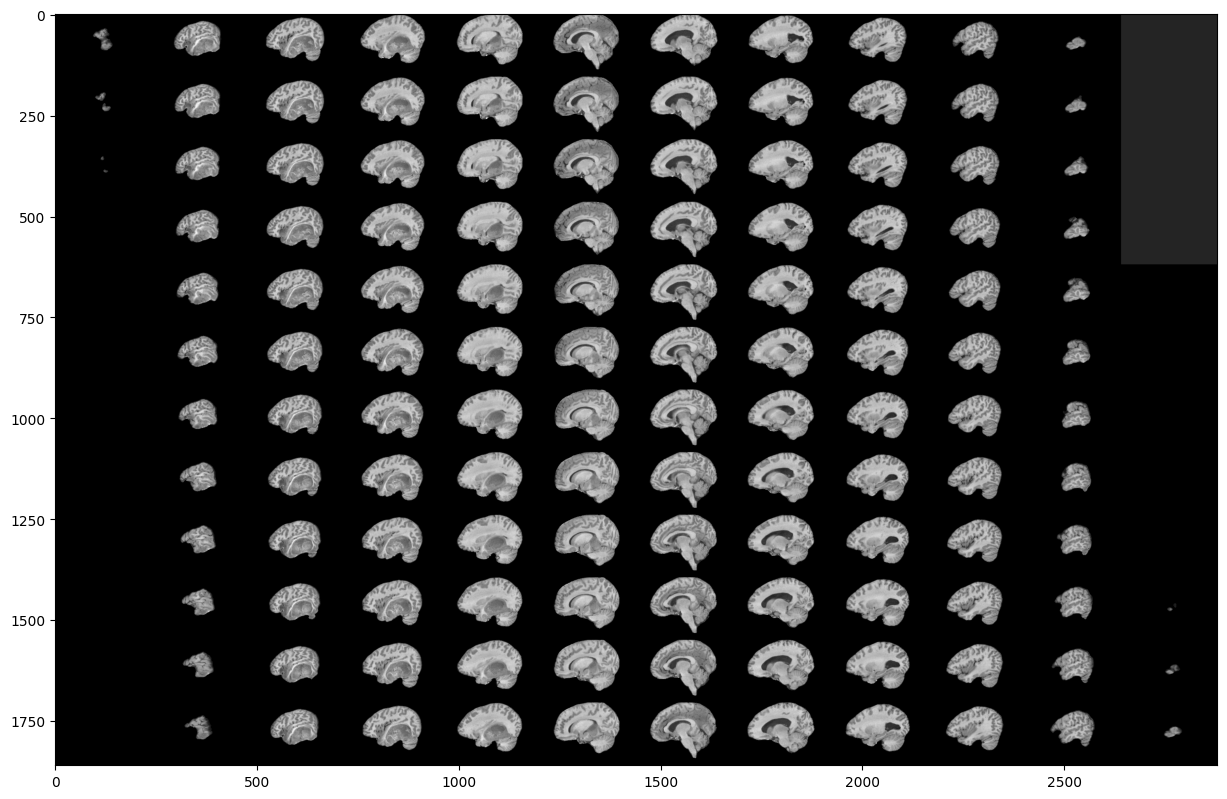

In [12]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

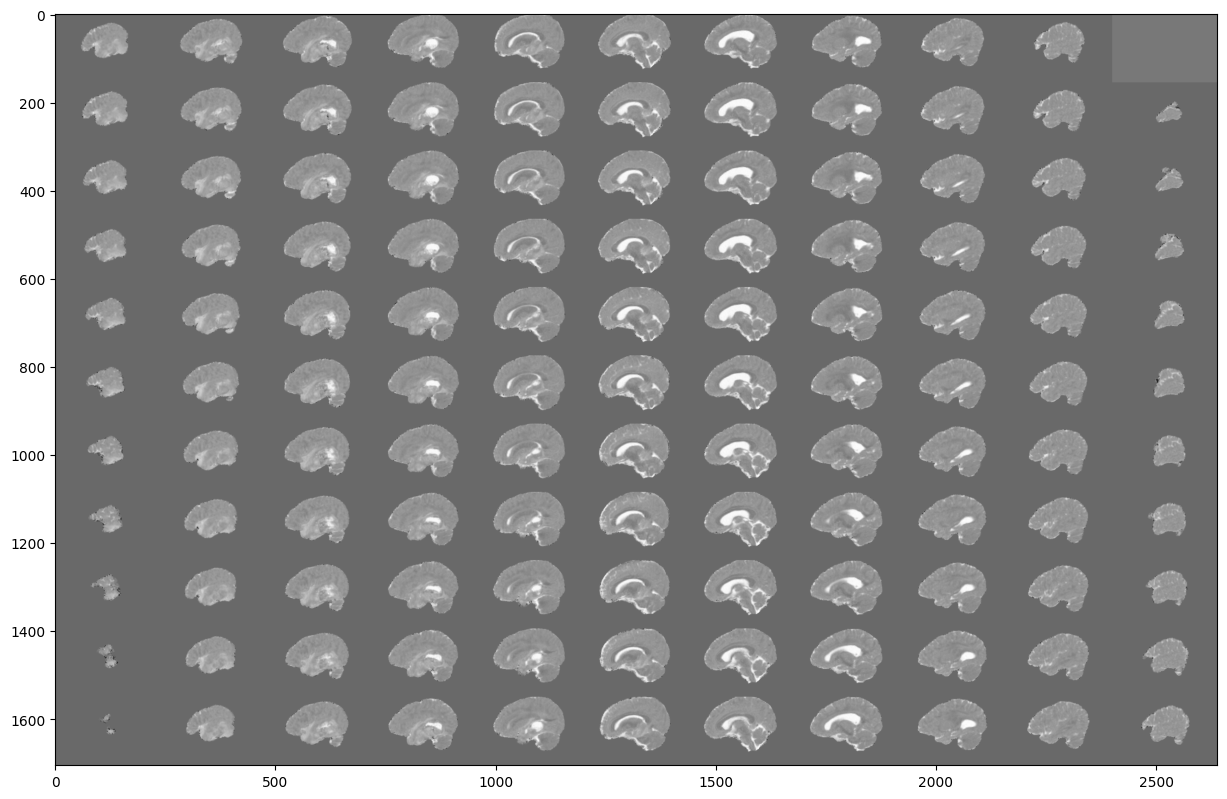

In [13]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

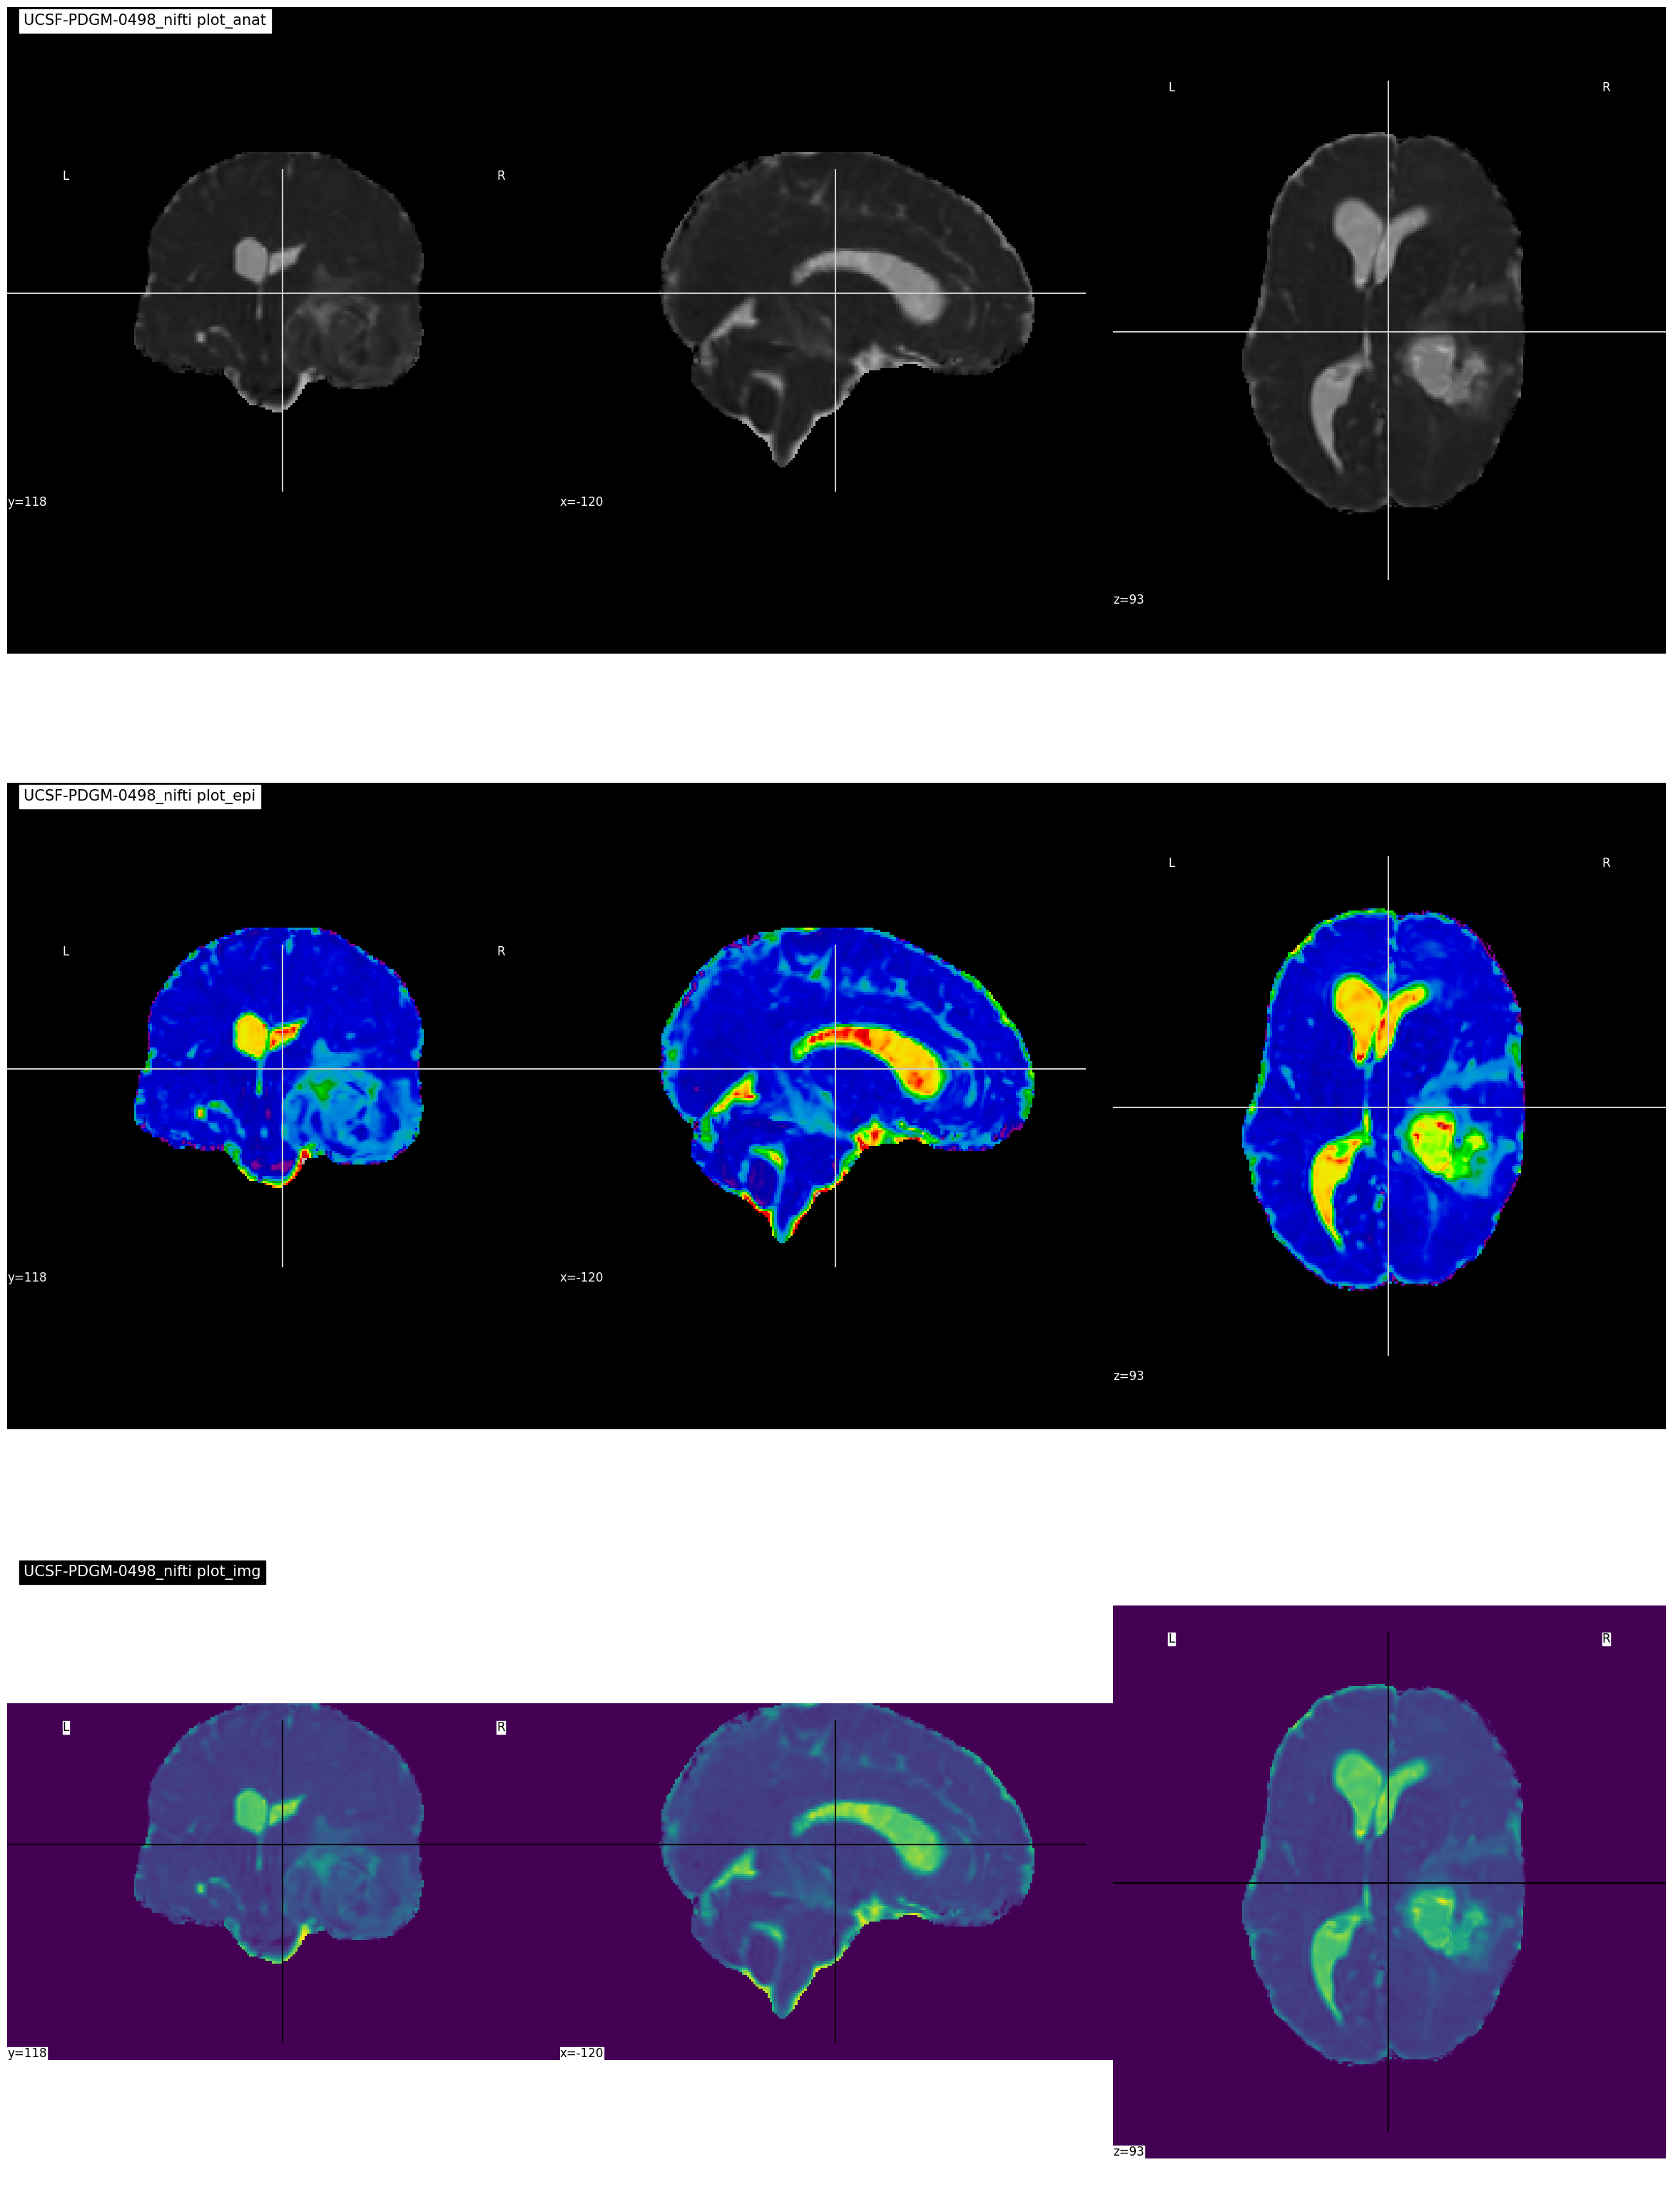

In [14]:
#Show the flair images in a different format
import nibabel as nib
import os
import nilearn.plotting as nlplt
import matplotlib.pyplot as plt

# Example ID
ID = "UCSF-PDGM-0498_nifti"

# List files within the directory associated with the ID
if ID in train_files:
    id_directory = os.path.join(data_directory, ID)
    files = os.listdir(id_directory)

    # Load NIfTI files for the specified ID
    if len(files) == 23:
        niimg = nib.load(os.path.join(id_directory, files[7]))

        fig, axes = plt.subplots(nrows=3, figsize=(30, 40))

        # Plot anatomical images
        # Visualize the brain's structural anatomy.
        # Anatomical images typically refer to high-resolution structural MRI
        nlplt.plot_anat(niimg,
                        title='UCSF-PDGM-0498_nifti plot_anat',
                        axes=axes[0])

        # Plot EPI (Echo Planar Imaging) images
        # Used in tasks like fMRI resting-state analysis and activation mapping.
        nlplt.plot_epi(niimg,
                       title='UCSF-PDGM-0498_nifti plot_epi',
                       axes=axes[1])

        nlplt.plot_img(niimg,
                       title='UCSF-PDGM-0498_nifti plot_img',
                       axes=axes[2])

        plt.show()
    else:
        print(f"Expected 23 files for ID '{ID}', but found {len(files)} files.")
else:
    print(f"ID '{ID}' not found in the training set.")

In [16]:
# dice loss as defined above for 4 classes
"""
This was taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net?scriptVersionId=61189746&cellId=18
"""
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [17]:
IMG_SIZE=128

In [18]:
from tensorflow.keras.optimizers.legacy import Adam
"""
This model was taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net?scriptVersionId=61189746&cellId=18
"""

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

# Input layer
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build the UNet model
model = build_unet(input_layer, 'he_normal', 0.2)

# Compile the model
model.compile(
    loss="categorical_crossentropy",  
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)


model.summary()

# Debugging: 
# for batch in range(len(training_generator)):
#     X_batch, Y_batch = training_generator[batch]
#     Y_pred = model.predict(X_batch)
#     print("y pred: ", Y_pred)
#     print("Y_batch: ", Y_batch)
    
#     # Check for negative values in predictions and targets
#     if tf.reduce_any(Y_pred < 0) or tf.reduce_any(Y_batch < 0):
#         print("Negative values found in predictions or targets in batch", batch)


2023-11-03 19:14:00.913725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 19:14:00.924009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 19:14:00.924272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  608         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

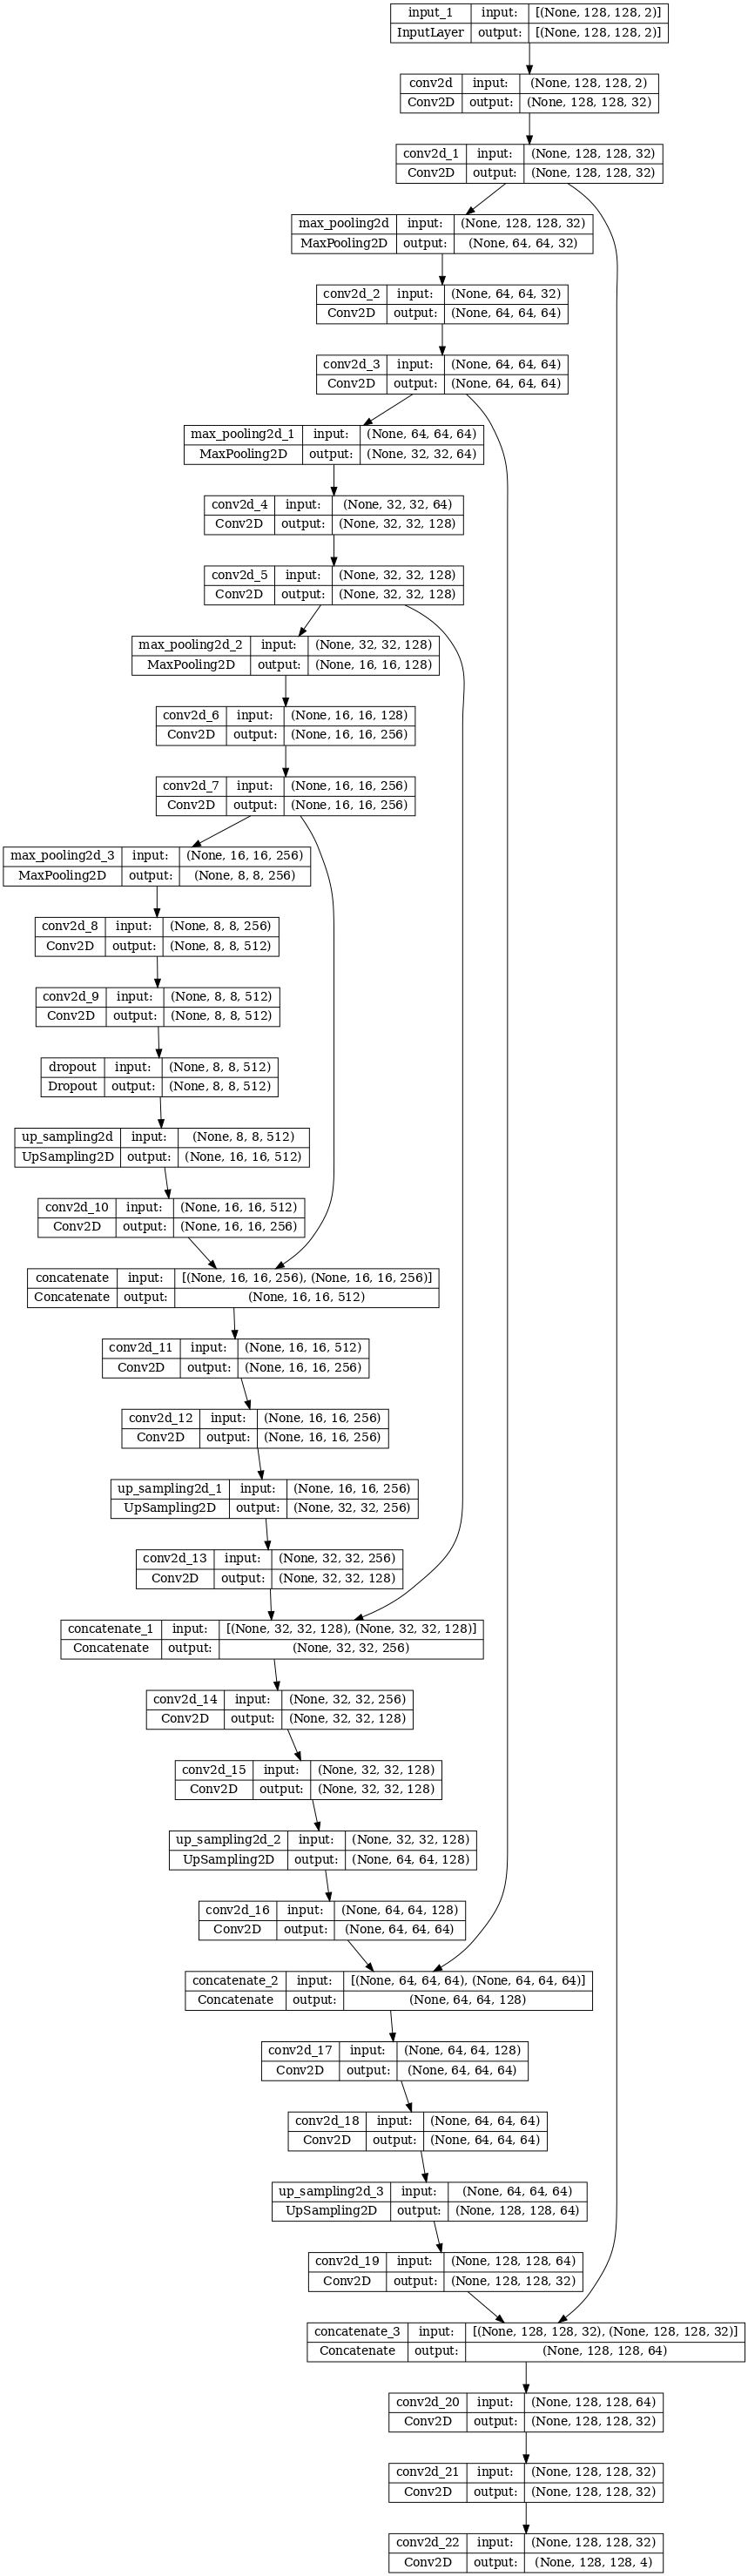

In [19]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [20]:
train_and_val_directories = TRAIN_DATASET_PATH + VAL_DATASET_PATH
train_and_val_directories

# Function to extract study IDs from directory paths
def pathListIntoIds(dirList):
    x = [dirList[i][dirList[i].rfind('/')+1:] for i in range(len(dirList))]
    return x


train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Split the IDs into training, testing, and validation sets
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)


In [22]:
import re  

def extractIDWithoutNifti(ID):
    # Remove "_nifti" and additional characters like "_FUXXXd"
    cleaned_id = re.sub(r'_nifti|_FU\d+d', '', ID)
    return cleaned_id

# Extract IDs without "_nifti" and additional characters based on the original IDs
train_ids_without_nifti = [extractIDWithoutNifti(ID) for ID in train_ids]
val_ids_without_nifti = [extractIDWithoutNifti(ID) for ID in val_ids]
test_ids_without_nifti = [extractIDWithoutNifti(ID) for ID in test_ids]

# Verify if the IDs have the correct format
for study_id in train_ids_without_nifti + val_ids_without_nifti + test_ids_without_nifti:
    if not re.match(r'^[A-Z0-9-]+$', study_id):
        print(f"Invalid study ID: {study_id}")



In [24]:
from skimage.transform import resize

"""
This class has been adapted for loading the UCSF-PDGM dataset from a Docker container.
This has been adapated from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net?scriptVersionId=61189746&cellId=26
"""

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_directory, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.data_directory = data_directory  
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(Batch_ids):
            # Extract study ID without '_nifti'
            nifti_without_id = extractIDWithoutNifti(i)
            # dir = data_directory + 
            
            case_path = os.path.join(self.data_directory, nifti_without_id+"_nifti") 

            data_path = os.path.join(case_path, f'{nifti_without_id}_FLAIR.nii') 
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{nifti_without_id}_T1c.nii')  
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{nifti_without_id}_tumor_segmentation.nii')  
            seg = nib.load(data_path).get_fdata()
            
            for j in range(VOLUME_SLICES):
                # Resize the flair and ce images
                X[j + VOLUME_SLICES * c, :, :, 0] = resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                # Assign the segmentation mask directly
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

#             for j in range(VOLUME_SLICES):
#                 X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
#                 X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

#                 y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]


        # Generate masks
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y


        
# training_generator = DataGenerator('/data/UCSF-PDGM-v3/', train_ids)
# valid_generator = DataGenerator('/data/UCSF-PDGM-v3/', val_ids)
# test_generator = DataGenerator('/data/UCSF-PDGM-v3/', test_ids)

training_generator = DataGenerator(data_directory, train_ids)
valid_generator = DataGenerator(data_directory, val_ids)
test_generator = DataGenerator(data_directory, test_ids)


In [25]:
# Remove "UCSF-PDGM-0541_nifti" from all lists
train_test_ids = [id for id in train_test_ids if id != "UCSF-PDGM-0541_nifti"]
val_ids = [id for id in val_ids if id != "UCSF-PDGM-0541_nifti"]
train_ids = [id for id in train_ids if id != "UCSF-PDGM-0541_nifti"]
test_ids = [id for id in test_ids if id != "UCSF-PDGM-0541_nifti"]

is_in_train_test_ids = "UCSF-PDGM-0541_nifti" in train_test_ids
is_in_val_ids = "UCSF-PDGM-0541_nifti" in val_ids
is_in_train_ids = "UCSF-PDGM-0541_nifti" in train_ids
is_in_test_ids = "UCSF-PDGM-0541_nifti" in test_ids

print(is_in_train_test_ids)
print(is_in_val_ids)
print(is_in_train_ids)
print(is_in_test_ids)

False
False
False
False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


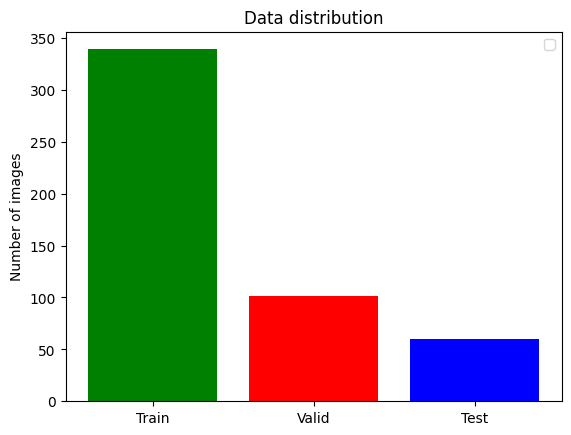

In [26]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [27]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [

      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

        csv_logger
    ]

In [102]:
callbacks

Uncomment this to train the model

In [35]:
# K.clear_session()

# history =  model.fit(training_generator,
#                     epochs=35,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )  
# # for epoch in range(35):
# #     for batch in training_generator:
# #         X_batch, Y_batch = batch
# #         predictions = model.predict(X_batch)  # Get predictions for the batch
# #         # Add debug output to check for negative predictions
# #         print("Batch Predictions: Min Value = {}, Max Value = {}".format(predictions.min(), predictions.max()))                    
# model.save("2D_model.h5")

In [ ]:
import os

def path_exists(path):
    """
    Check if a path exists.

    Args:
    path (str): The path to check.

    Returns:
    bool: True if the path exists, False if it does not.
    """
    return os.path.exists(path)

path = "/data/UCSF-PDGM-0541_nifti/UCSF-PDGM-0541_tumor_segmentation.nii"
if path_exists(path):
    print(f"The path '{path}' exists.")
else:
    print(f"The path '{path}' does not exist.")

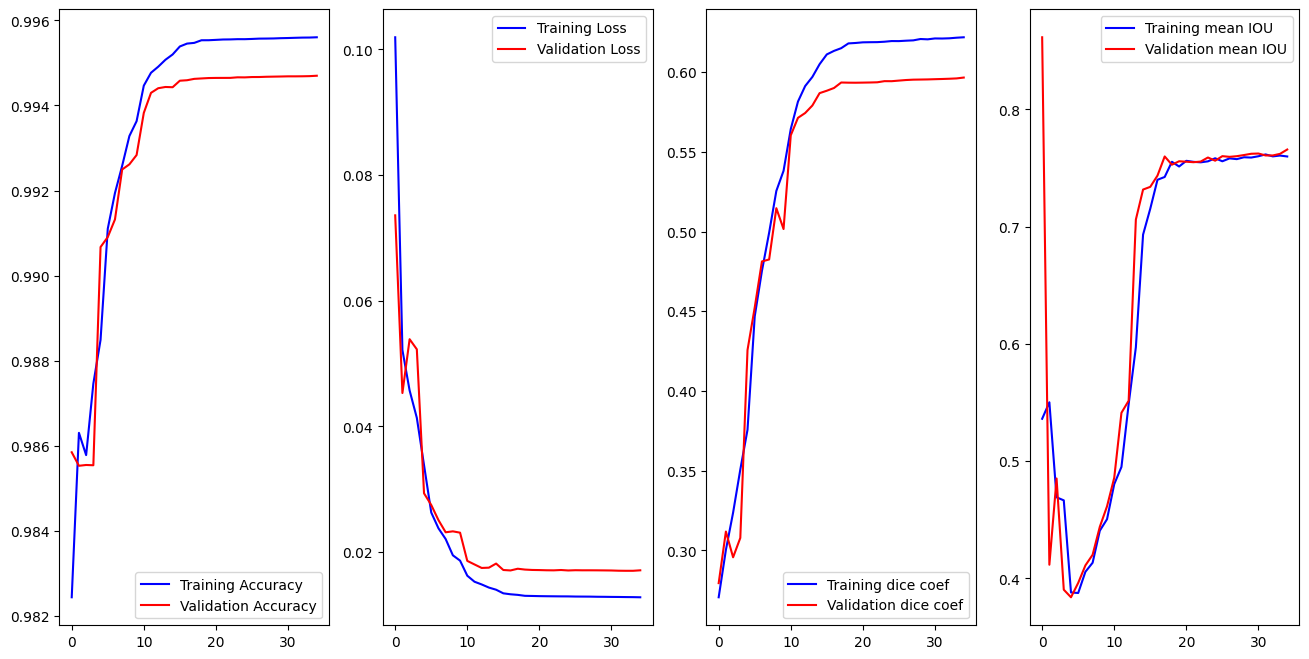

In [28]:
############ load trained model ################
model = keras.models.load_model('2D_model.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [33]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
"""
These methods are used to load the images from the directories and paths.
These have been adapted from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net?scriptVersionId=61189746&cellId=36
"""
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j + VOLUME_SLICES * c, :, :, 0] = np.array(Image.fromarray(image[:, :, j + VOLUME_START_AT]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))
        X[j + VOLUME_SLICES * c, :, :, 1] = np.array(Image.fromarray(ce[:, :, j + VOLUME_START_AT]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))
        y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

    return np.array(image)



# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
from PIL import Image

def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also its mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = np.array(Image.fromarray(currentScanVolume[:, :, j]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST), dtype='float32')
            mask_img = np.array(Image.fromarray(currentMaskVolume[:, :, j]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST), dtype='float32')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

In [94]:
"""
This method has been adapted from https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net?scriptVersionId=61189746&cellId=37
"""
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    vol_path = os.path.join(case_path, extractIDWithoutNifti(case)+"_FLAIR.nii")
    flair = nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, extractIDWithoutNifti(case)+"_T1c.nii")
    ce = nib.load(vol_path).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = np.array(Image.fromarray(flair[:, :, j + VOLUME_START_AT]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))
        X[j, :, :, 1] = np.array(Image.fromarray(ce[:, :, j + VOLUME_START_AT]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))

    # Perform the predictions on the resized images
    predictions = model.predict(X / np.max(X), verbose=1)
    
    return predictions


In [95]:
"""
This method is used to predict by ID and is adapted from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net?scriptVersionId=61189746&cellId=37
"""
def showPredictsById(case, start_slice = 60):
#     print(case_path)
    case_path = "/data/"+case
#     print(extractIDWithoutNifti(test_ids[0]))
    gt_path = "/data/"+case+"/"+extractIDWithoutNifti(case)+"_tumor_segmentation.nii"
    origImage_path = "/data/"+case+"/"+extractIDWithoutNifti(case)+"_FLAIR.nii"

    gt = nib.load(gt_path).get_fdata()
    origImage = nib.load(origImage_path).get_fdata()
    p = predictByPath(case_path, case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]
    
    
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):  # for each image, add brain background
        axarr[i].imshow(origImage[:, :, start_slice + VOLUME_START_AT], cmap="gray", interpolation='none')

    axarr[0].imshow(origImage[:, :, start_slice + VOLUME_START_AT], cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt = gt[:, :, start_slice + VOLUME_START_AT]
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)  # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

In [105]:
# test_ids

4/4 [==============================] - 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

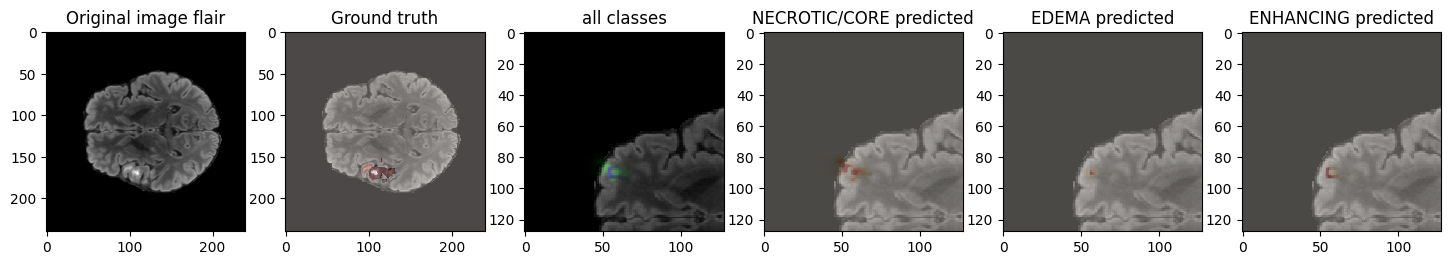

4/4 [==============================] - 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

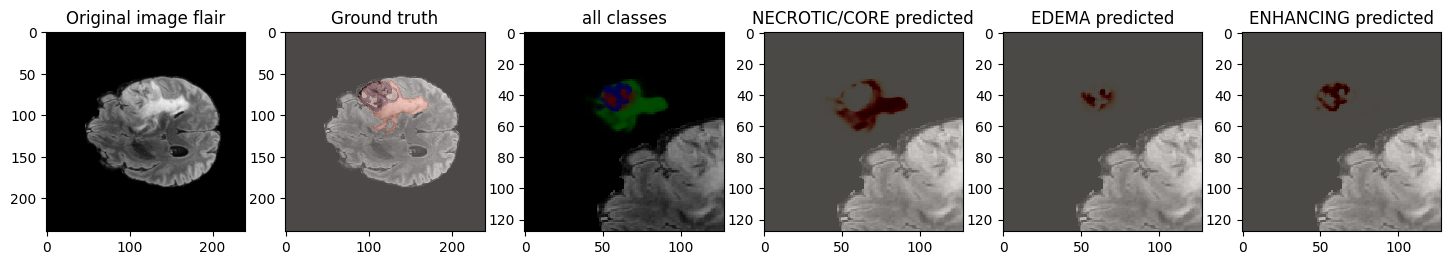

4/4 [==============================] - 0s 37ms/step


<Figure size 1800x5000 with 0 Axes>

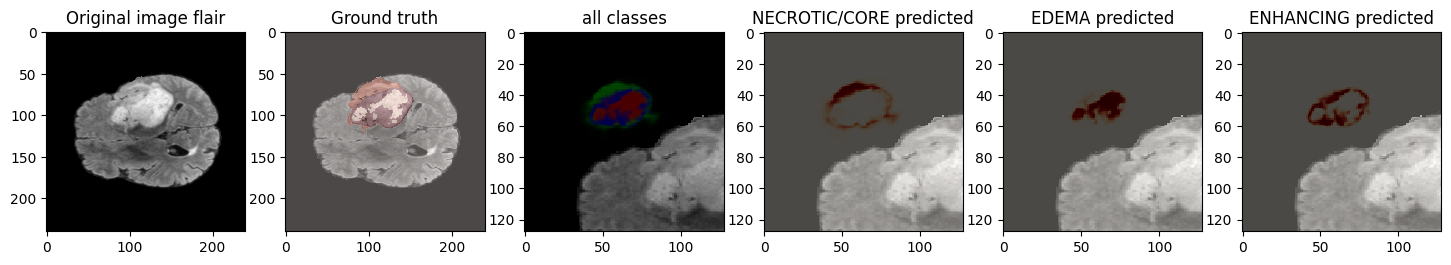

4/4 [==============================] - 0s 38ms/step


<Figure size 1800x5000 with 0 Axes>

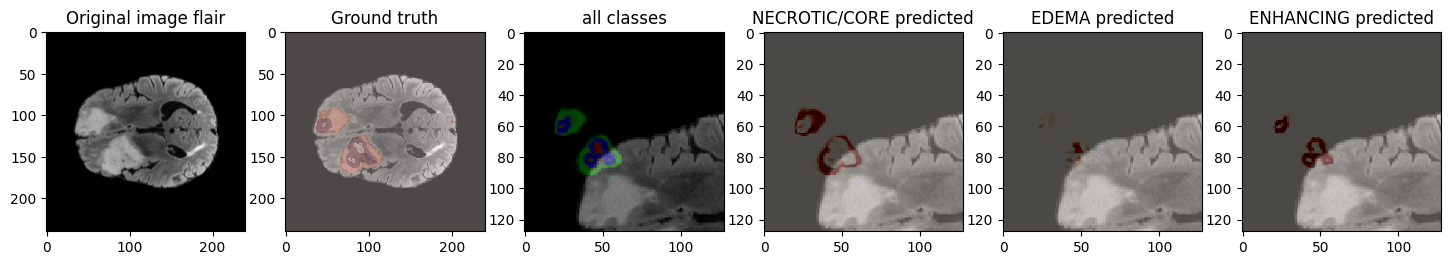

4/4 [==============================] - 0s 38ms/step


<Figure size 1800x5000 with 0 Axes>

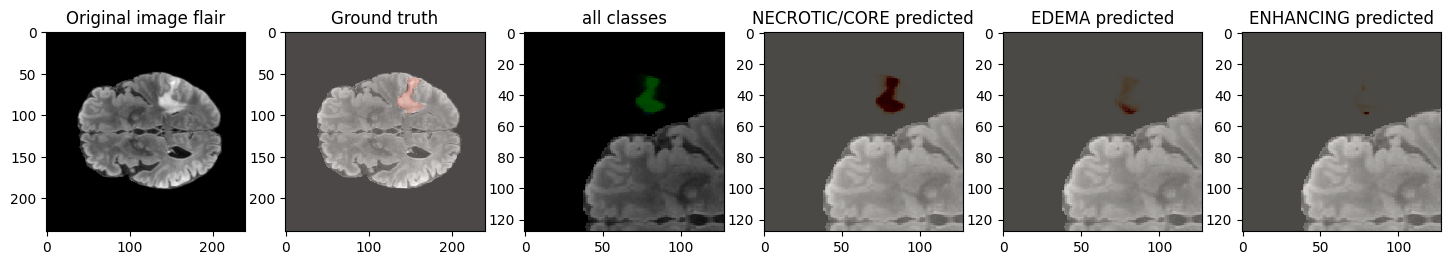

4/4 [==============================] - 0s 38ms/step


<Figure size 1800x5000 with 0 Axes>

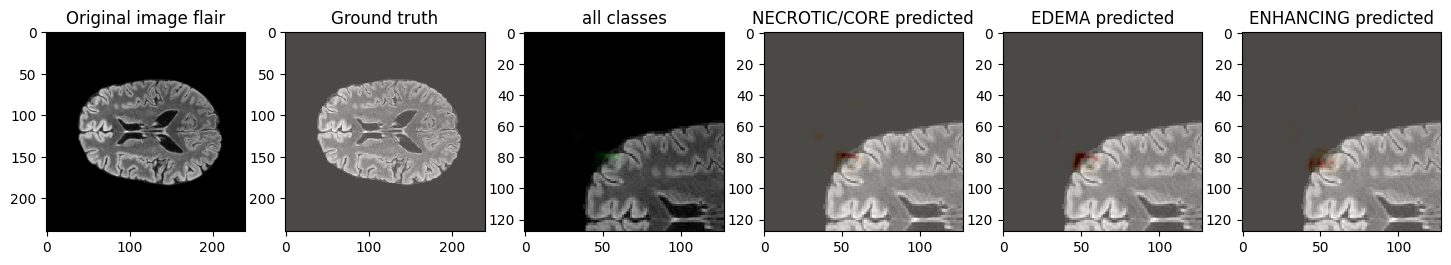

4/4 [==============================] - 0s 38ms/step


<Figure size 1800x5000 with 0 Axes>

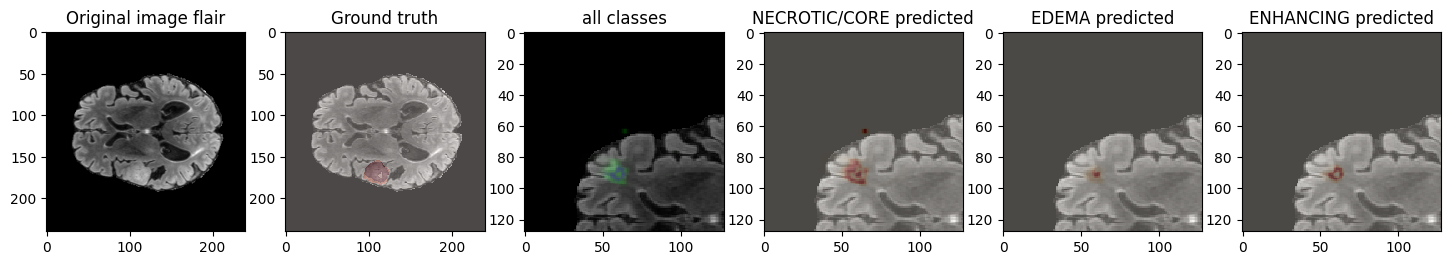

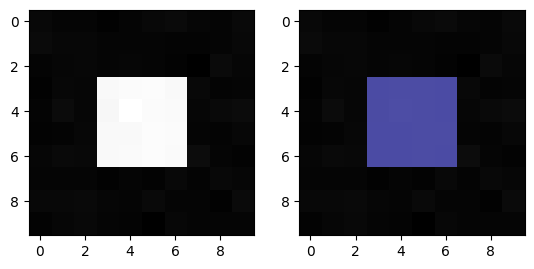

In [100]:
showPredictsById(case=test_ids[0])
showPredictsById(case=test_ids[1])
showPredictsById(case=test_ids[2])
showPredictsById(case=test_ids[3])
showPredictsById(case=test_ids[4])
showPredictsById(case=test_ids[5])
showPredictsById(case=test_ids[6])

mask = np.zeros((10,10))
mask[3:-3, 3:-3] = 1 # white square in black background
im = mask + np.random.randn(10,10) * 0.01 # random image
masked = np.ma.masked_where(mask == 0, mask)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(im, 'gray', interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
plt.show()

4/4 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

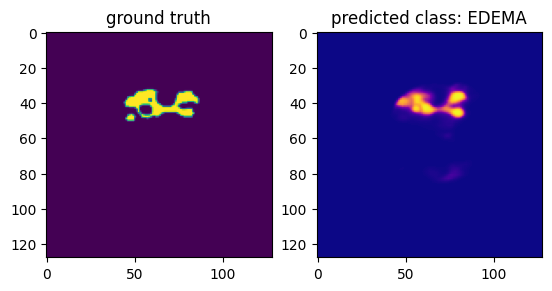

In [121]:
from skimage.transform import resize

"""
Get visualisations of predictions
"""

case = case=test_ids[1]
path = "/data/"+case
gt_path = "/data/"+case+"/"+extractIDWithoutNifti(case)+"_tumor_segmentation.nii"
gt = nib.load(gt_path).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema = p[:,:,:,2]
enhancing = p[:,:,:,3]

i = 40  # slice at
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

gt[gt != eval_class] = 1  # use only one class for per class evaluation

resized_gt = resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="viridis")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="plasma")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()


In [113]:
"""
Evaluate the model
"""
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)



Evaluate on test data


2023-11-03 20:20:34.002787: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 25s 371ms/step - loss: 0.0136 - accuracy: 0.9952 - mean_io_u_2: 0.7641 - dice_coef: 0.6246 - precision: 0.9953 - sensitivity: 0.9942 - specificity: 0.9984 - dice_coef_necrotic: 0.5220 - dice_coef_edema: 0.7503 - dice_coef_enhancing: 0.6514
test loss, test acc: [0.01363442000001669, 0.9952207803726196, 0.7640625238418579, 0.6246000528335571, 0.9952878355979919, 0.9942043423652649, 0.9984077215194702, 0.5219959020614624, 0.7503048777580261, 0.6514140367507935]


Evaluate on test data
2023-11-03 20:20:34.002787: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
60/60 [==============================] - 25s 371ms/step - loss: 0.0136 - accuracy: 0.9952 - mean_io_u_2: 0.7641 - dice_coef: 0.6246 - precision: 0.9953 - sensitivity: 0.9942 - specificity: 0.9984 - dice_coef_necrotic: 0.5220 - dice_coef_edema: 0.7503 - dice_coef_enhancing: 0.6514
test loss, test acc: [0.01363442000001669, 0.9952207803726196, 0.7640625238418579, 0.6246000528335571, 0.9952878355979919, 0.9942043423652649, 0.9984077215194702, 0.5219959020614624, 0.7503048777580261, 0.6514140367507935]

In [125]:
import pandas as pd


metrics = ['Loss', 'Accuracy', 'Mean IoU', 'Dice Coef', 'Precision', 'Sensitivity', 'Specificity', 'Dice Coef Necrotic', 'Dice Coef Edema', 'Dice Coef Enhancing']
results = [0.01363442000001669, 0.9952207803726196, 0.7640625238418579, 0.6246000528335571, 0.9952878355979919, 0.9942043423652649, 0.9984077215194702, 0.5219959020614624, 0.7503048777580261, 0.6514140367507935]


df = pd.DataFrame({'Metric': metrics, 'Result': results})



df


,Metric,Result
0,Loss,0.013634
1,Accuracy,0.995221
2,Mean IoU,0.764063
3,Dice Coef,0.624600
4,Precision,0.995288
5,Sensitivity,0.994204
6,Specificity,0.998408
7,Dice Coef Necrotic,0.521996
8,Dice Coef Edema,0.750305
9,Dice Coef Enhancing,0.651414
